# Breaking a CAPTCHA system

Ref: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710

In [97]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

Install some packages below (if not installed already):

In [ ]:
!pip install opencv-python
!pip install imutils
!conda install pydot -y
!conda install graphviz -y

In [ ]:
!brew install graphviz # only for mac, for other OS, please search the relevant command to install
!brew install wget # only for mac; Linux should work fine, Windows has no wget

In this exercise you will break `Really Simple CAPTCHA` plugin of WordPress: https://wordpress.org/plugins/really-simple-captcha/

Try a demo here: https://contactform7.com/captcha/

The plugin generates 4-letter CAPTCHAs using a random mix of four different fonts. Letters are from 'ABCDEFGHJKLMNPQRSTUVWXYZ23456789' and "O", "I" and "1" are not used to avoid user confusion. That leaves us with a total of 32 possible letters and numbers that we need to recognize.

Since we have the source code to the WordPress plug-in, we can modify it to save out CAPTCHA images along with the expected answer for each image. We generated 9955 images under folder `generated_captcha_images`. Run the following code to show 10 images to take a look.

In [98]:
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"

## Step 1: Extract single letters from CAPTCHA images

### Run the following code to show 10 images to take a look.

In [99]:
import os.path
import glob # glob.glob returns the list of files with their full path, and it supports wildcards

from IPython.display import Image

captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))

for (i, captcha_image_file) in enumerate(captcha_image_files):
    if i==10: break
    print(captcha_image_file)
    display(Image(filename=captcha_image_file))

generated_captcha_images\222X.png


generated_captcha_images\226U.png


generated_captcha_images\2274.png


generated_captcha_images\22A6.png


generated_captcha_images\22BJ.png


generated_captcha_images\22HS.png


generated_captcha_images\22KD.png


generated_captcha_images\22L9.png


generated_captcha_images\22NR.png


generated_captcha_images\22PL.png


### Now we illustrate how to process an image `generated_captcha_images/222X.png`

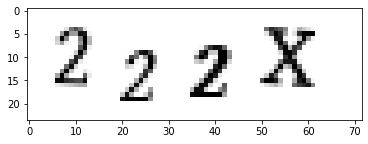

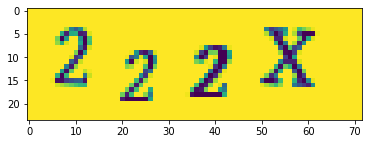

In [100]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt
import cv2 # OpenCV, a popular framework for computer vision and image processing

captcha_image_file = 'generated_captcha_images/222X.png' # normal
# captcha_image_file = 'generated_captcha_images/2W4M.png' # try this: 3 objects, 2 letters are merged
# captcha_image_file = 'generated_captcha_images/3PH3.png' # try this: 5 objects detected
# captcha_image_file = 'generated_captcha_images/JYU4.png' # try this: 6 objects detected

captcha_correct_text = os.path.splitext(captcha_image_file)[0]

# Load the image and convert it to grayscale
image = cv2.imread(captcha_image_file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Show the image with matplotlib
plt.imshow(image)
plt.show()

plt.imshow(gray)
plt.show()

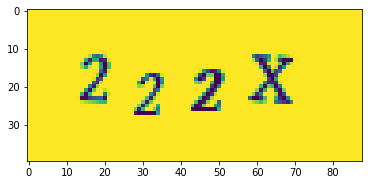

In [101]:
# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

plt.imshow(gray)
plt.show()

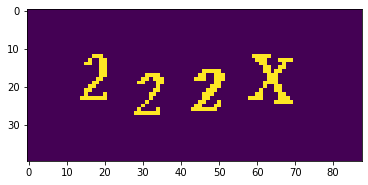

In [102]:
# threshold the image (convert it to pure black and white)
# we use Otsu’s binarization
# check: https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

plt.imshow(thresh)
plt.show()

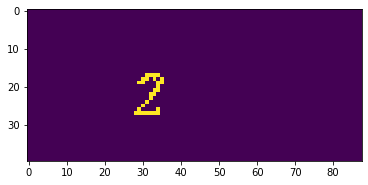

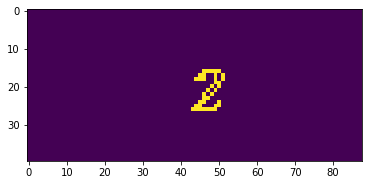

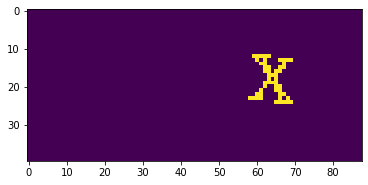

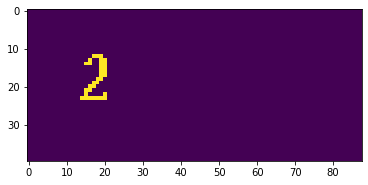

In [103]:
import numpy as np

# find the contours (continuous blobs of pixels) the image
# check:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html#contours-getting-started
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# !!! if the cell reports error, replace [0] above with [1]

zero_img = np.zeros_like(thresh)

for i in range(len(contours)):
    temp = cv2.drawContours(zero_img.copy(), contours, i, (255,0,0), 1)
    plt.imshow(temp)
    plt.show()

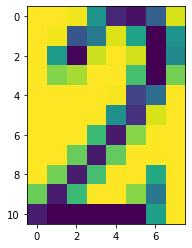

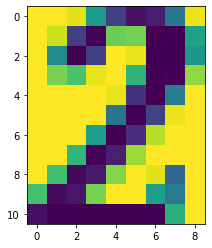

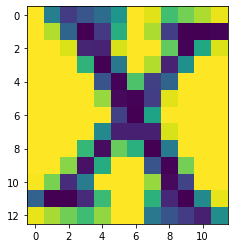

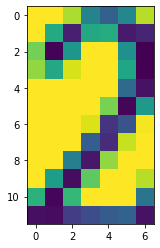

In [104]:
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    letter_image = gray[y:y+h, x:x+w]
    plt.imshow(letter_image)
    plt.show()

### Putting things together: get letters from images

Using what we have learnt above, write your code to save get the letters of all images. The letter-images are stored as 32 folders under folder `extracted_letter_images`.

For example, `extracted_letter_images/A` is a folder that saves all images of letter `A`. After you complete, each letter-folder should contain over 1000 letter-images.

Hint: (1) consider how to name different files in a letter-folder differently? (2) ingore those images with number of contours other than 4.

In [105]:
import os
import os.path
import glob
import imutils
import cv2


LETTER_IMAGES_FOLDER = "extracted_letter_images" # the output for training
SKIPPED_FOLDER = "skipped_images" # those images are skipped
counts = {} # counts['A'] = number of 'A'-images, so that next 'A'-image can be named as counts['A'] + 1

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

     # grab the file name
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Loads the image and change to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Adds the extra padding to the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # threshold the image and converting to black and white
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (the image)
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    #hacks the compatability of different versions
    #contours = contours[0] if imutils.is_cv2() else contours[1]

    letter_image_regions = []

    #loop for 4 contours
    for contour in contours:
        # Gets the rectangle which contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare countour width and height to detect letters
        if w / h > 1.25:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))

    # skip when it found less or more then four letters in the captcha
    if len(letter_image_regions) != 4:
        cv2.imwrite(SKIPPED_FOLDER + "/" + captcha_correct_text + ".png", image)
        #process from left to right
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    #save each single letter as one image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        
        x, y, w, h = letter_bounding_box
        #extract the original one having 2 pixel margin around.
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        #folder to save image
        save_path = os.path.join(LETTER_IMAGES_FOLDER, letter_text)
        #output directory
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        #writes from image to file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)
        
        #increment
        counts[letter_text] = count + 1

    

[INFO] processing image 1/9955
[INFO] processing image 2/9955
[INFO] processing image 3/9955
[INFO] processing image 4/9955
[INFO] processing image 5/9955
[INFO] processing image 6/9955
[INFO] processing image 7/9955
[INFO] processing image 8/9955
[INFO] processing image 9/9955
[INFO] processing image 10/9955
[INFO] processing image 11/9955
[INFO] processing image 12/9955
[INFO] processing image 13/9955
[INFO] processing image 14/9955
[INFO] processing image 15/9955
[INFO] processing image 16/9955
[INFO] processing image 17/9955
[INFO] processing image 18/9955
[INFO] processing image 19/9955
[INFO] processing image 20/9955
[INFO] processing image 21/9955
[INFO] processing image 22/9955
[INFO] processing image 23/9955
[INFO] processing image 24/9955
[INFO] processing image 25/9955
[INFO] processing image 26/9955
[INFO] processing image 27/9955
[INFO] processing image 28/9955
[INFO] processing image 29/9955
[INFO] processing image 30/9955
[INFO] processing image 31/9955
[INFO] processing

[INFO] processing image 263/9955
[INFO] processing image 264/9955
[INFO] processing image 265/9955
[INFO] processing image 266/9955
[INFO] processing image 267/9955
[INFO] processing image 268/9955
[INFO] processing image 269/9955
[INFO] processing image 270/9955
[INFO] processing image 271/9955
[INFO] processing image 272/9955
[INFO] processing image 273/9955
[INFO] processing image 274/9955
[INFO] processing image 275/9955
[INFO] processing image 276/9955
[INFO] processing image 277/9955
[INFO] processing image 278/9955
[INFO] processing image 279/9955
[INFO] processing image 280/9955
[INFO] processing image 281/9955
[INFO] processing image 282/9955
[INFO] processing image 283/9955
[INFO] processing image 284/9955
[INFO] processing image 285/9955
[INFO] processing image 286/9955
[INFO] processing image 287/9955
[INFO] processing image 288/9955
[INFO] processing image 289/9955
[INFO] processing image 290/9955
[INFO] processing image 291/9955
[INFO] processing image 292/9955
[INFO] pro

[INFO] processing image 518/9955
[INFO] processing image 519/9955
[INFO] processing image 520/9955
[INFO] processing image 521/9955
[INFO] processing image 522/9955
[INFO] processing image 523/9955
[INFO] processing image 524/9955
[INFO] processing image 525/9955
[INFO] processing image 526/9955
[INFO] processing image 527/9955
[INFO] processing image 528/9955
[INFO] processing image 529/9955
[INFO] processing image 530/9955
[INFO] processing image 531/9955
[INFO] processing image 532/9955
[INFO] processing image 533/9955
[INFO] processing image 534/9955
[INFO] processing image 535/9955
[INFO] processing image 536/9955
[INFO] processing image 537/9955
[INFO] processing image 538/9955
[INFO] processing image 539/9955
[INFO] processing image 540/9955
[INFO] processing image 541/9955
[INFO] processing image 542/9955
[INFO] processing image 543/9955
[INFO] processing image 544/9955
[INFO] processing image 545/9955
[INFO] processing image 546/9955
[INFO] processing image 547/9955
[INFO] pro

[INFO] processing image 773/9955
[INFO] processing image 774/9955
[INFO] processing image 775/9955
[INFO] processing image 776/9955
[INFO] processing image 777/9955
[INFO] processing image 778/9955
[INFO] processing image 779/9955
[INFO] processing image 780/9955
[INFO] processing image 781/9955
[INFO] processing image 782/9955
[INFO] processing image 783/9955
[INFO] processing image 784/9955
[INFO] processing image 785/9955
[INFO] processing image 786/9955
[INFO] processing image 787/9955
[INFO] processing image 788/9955
[INFO] processing image 789/9955
[INFO] processing image 790/9955
[INFO] processing image 791/9955
[INFO] processing image 792/9955
[INFO] processing image 793/9955
[INFO] processing image 794/9955
[INFO] processing image 795/9955
[INFO] processing image 796/9955
[INFO] processing image 797/9955
[INFO] processing image 798/9955
[INFO] processing image 799/9955
[INFO] processing image 800/9955
[INFO] processing image 801/9955
[INFO] processing image 802/9955
[INFO] pro

[INFO] processing image 1033/9955
[INFO] processing image 1034/9955
[INFO] processing image 1035/9955
[INFO] processing image 1036/9955
[INFO] processing image 1037/9955
[INFO] processing image 1038/9955
[INFO] processing image 1039/9955
[INFO] processing image 1040/9955
[INFO] processing image 1041/9955
[INFO] processing image 1042/9955
[INFO] processing image 1043/9955
[INFO] processing image 1044/9955
[INFO] processing image 1045/9955
[INFO] processing image 1046/9955
[INFO] processing image 1047/9955
[INFO] processing image 1048/9955
[INFO] processing image 1049/9955
[INFO] processing image 1050/9955
[INFO] processing image 1051/9955
[INFO] processing image 1052/9955
[INFO] processing image 1053/9955
[INFO] processing image 1054/9955
[INFO] processing image 1055/9955
[INFO] processing image 1056/9955
[INFO] processing image 1057/9955
[INFO] processing image 1058/9955
[INFO] processing image 1059/9955
[INFO] processing image 1060/9955
[INFO] processing image 1061/9955
[INFO] process

[INFO] processing image 1277/9955
[INFO] processing image 1278/9955
[INFO] processing image 1279/9955
[INFO] processing image 1280/9955
[INFO] processing image 1281/9955
[INFO] processing image 1282/9955
[INFO] processing image 1283/9955
[INFO] processing image 1284/9955
[INFO] processing image 1285/9955
[INFO] processing image 1286/9955
[INFO] processing image 1287/9955
[INFO] processing image 1288/9955
[INFO] processing image 1289/9955
[INFO] processing image 1290/9955
[INFO] processing image 1291/9955
[INFO] processing image 1292/9955
[INFO] processing image 1293/9955
[INFO] processing image 1294/9955
[INFO] processing image 1295/9955
[INFO] processing image 1296/9955
[INFO] processing image 1297/9955
[INFO] processing image 1298/9955
[INFO] processing image 1299/9955
[INFO] processing image 1300/9955
[INFO] processing image 1301/9955
[INFO] processing image 1302/9955
[INFO] processing image 1303/9955
[INFO] processing image 1304/9955
[INFO] processing image 1305/9955
[INFO] process

[INFO] processing image 1548/9955
[INFO] processing image 1549/9955
[INFO] processing image 1550/9955
[INFO] processing image 1551/9955
[INFO] processing image 1552/9955
[INFO] processing image 1553/9955
[INFO] processing image 1554/9955
[INFO] processing image 1555/9955
[INFO] processing image 1556/9955
[INFO] processing image 1557/9955
[INFO] processing image 1558/9955
[INFO] processing image 1559/9955
[INFO] processing image 1560/9955
[INFO] processing image 1561/9955
[INFO] processing image 1562/9955
[INFO] processing image 1563/9955
[INFO] processing image 1564/9955
[INFO] processing image 1565/9955
[INFO] processing image 1566/9955
[INFO] processing image 1567/9955
[INFO] processing image 1568/9955
[INFO] processing image 1569/9955
[INFO] processing image 1570/9955
[INFO] processing image 1571/9955
[INFO] processing image 1572/9955
[INFO] processing image 1573/9955
[INFO] processing image 1574/9955
[INFO] processing image 1575/9955
[INFO] processing image 1576/9955
[INFO] process

[INFO] processing image 1799/9955
[INFO] processing image 1800/9955
[INFO] processing image 1801/9955
[INFO] processing image 1802/9955
[INFO] processing image 1803/9955
[INFO] processing image 1804/9955
[INFO] processing image 1805/9955
[INFO] processing image 1806/9955
[INFO] processing image 1807/9955
[INFO] processing image 1808/9955
[INFO] processing image 1809/9955
[INFO] processing image 1810/9955
[INFO] processing image 1811/9955
[INFO] processing image 1812/9955
[INFO] processing image 1813/9955
[INFO] processing image 1814/9955
[INFO] processing image 1815/9955
[INFO] processing image 1816/9955
[INFO] processing image 1817/9955
[INFO] processing image 1818/9955
[INFO] processing image 1819/9955
[INFO] processing image 1820/9955
[INFO] processing image 1821/9955
[INFO] processing image 1822/9955
[INFO] processing image 1823/9955
[INFO] processing image 1824/9955
[INFO] processing image 1825/9955
[INFO] processing image 1826/9955
[INFO] processing image 1827/9955
[INFO] process

[INFO] processing image 2069/9955
[INFO] processing image 2070/9955
[INFO] processing image 2071/9955
[INFO] processing image 2072/9955
[INFO] processing image 2073/9955
[INFO] processing image 2074/9955
[INFO] processing image 2075/9955
[INFO] processing image 2076/9955
[INFO] processing image 2077/9955
[INFO] processing image 2078/9955
[INFO] processing image 2079/9955
[INFO] processing image 2080/9955
[INFO] processing image 2081/9955
[INFO] processing image 2082/9955
[INFO] processing image 2083/9955
[INFO] processing image 2084/9955
[INFO] processing image 2085/9955
[INFO] processing image 2086/9955
[INFO] processing image 2087/9955
[INFO] processing image 2088/9955
[INFO] processing image 2089/9955
[INFO] processing image 2090/9955
[INFO] processing image 2091/9955
[INFO] processing image 2092/9955
[INFO] processing image 2093/9955
[INFO] processing image 2094/9955
[INFO] processing image 2095/9955
[INFO] processing image 2096/9955
[INFO] processing image 2097/9955
[INFO] process

[INFO] processing image 2319/9955
[INFO] processing image 2320/9955
[INFO] processing image 2321/9955
[INFO] processing image 2322/9955
[INFO] processing image 2323/9955
[INFO] processing image 2324/9955
[INFO] processing image 2325/9955
[INFO] processing image 2326/9955
[INFO] processing image 2327/9955
[INFO] processing image 2328/9955
[INFO] processing image 2329/9955
[INFO] processing image 2330/9955
[INFO] processing image 2331/9955
[INFO] processing image 2332/9955
[INFO] processing image 2333/9955
[INFO] processing image 2334/9955
[INFO] processing image 2335/9955
[INFO] processing image 2336/9955
[INFO] processing image 2337/9955
[INFO] processing image 2338/9955
[INFO] processing image 2339/9955
[INFO] processing image 2340/9955
[INFO] processing image 2341/9955
[INFO] processing image 2342/9955
[INFO] processing image 2343/9955
[INFO] processing image 2344/9955
[INFO] processing image 2345/9955
[INFO] processing image 2346/9955
[INFO] processing image 2347/9955
[INFO] process

[INFO] processing image 2575/9955
[INFO] processing image 2576/9955
[INFO] processing image 2577/9955
[INFO] processing image 2578/9955
[INFO] processing image 2579/9955
[INFO] processing image 2580/9955
[INFO] processing image 2581/9955
[INFO] processing image 2582/9955
[INFO] processing image 2583/9955
[INFO] processing image 2584/9955
[INFO] processing image 2585/9955
[INFO] processing image 2586/9955
[INFO] processing image 2587/9955
[INFO] processing image 2588/9955
[INFO] processing image 2589/9955
[INFO] processing image 2590/9955
[INFO] processing image 2591/9955
[INFO] processing image 2592/9955
[INFO] processing image 2593/9955
[INFO] processing image 2594/9955
[INFO] processing image 2595/9955
[INFO] processing image 2596/9955
[INFO] processing image 2597/9955
[INFO] processing image 2598/9955
[INFO] processing image 2599/9955
[INFO] processing image 2600/9955
[INFO] processing image 2601/9955
[INFO] processing image 2602/9955
[INFO] processing image 2603/9955
[INFO] process

[INFO] processing image 2846/9955
[INFO] processing image 2847/9955
[INFO] processing image 2848/9955
[INFO] processing image 2849/9955
[INFO] processing image 2850/9955
[INFO] processing image 2851/9955
[INFO] processing image 2852/9955
[INFO] processing image 2853/9955
[INFO] processing image 2854/9955
[INFO] processing image 2855/9955
[INFO] processing image 2856/9955
[INFO] processing image 2857/9955
[INFO] processing image 2858/9955
[INFO] processing image 2859/9955
[INFO] processing image 2860/9955
[INFO] processing image 2861/9955
[INFO] processing image 2862/9955
[INFO] processing image 2863/9955
[INFO] processing image 2864/9955
[INFO] processing image 2865/9955
[INFO] processing image 2866/9955
[INFO] processing image 2867/9955
[INFO] processing image 2868/9955
[INFO] processing image 2869/9955
[INFO] processing image 2870/9955
[INFO] processing image 2871/9955
[INFO] processing image 2872/9955
[INFO] processing image 2873/9955
[INFO] processing image 2874/9955
[INFO] process

[INFO] processing image 3108/9955
[INFO] processing image 3109/9955
[INFO] processing image 3110/9955
[INFO] processing image 3111/9955
[INFO] processing image 3112/9955
[INFO] processing image 3113/9955
[INFO] processing image 3114/9955
[INFO] processing image 3115/9955
[INFO] processing image 3116/9955
[INFO] processing image 3117/9955
[INFO] processing image 3118/9955
[INFO] processing image 3119/9955
[INFO] processing image 3120/9955
[INFO] processing image 3121/9955
[INFO] processing image 3122/9955
[INFO] processing image 3123/9955
[INFO] processing image 3124/9955
[INFO] processing image 3125/9955
[INFO] processing image 3126/9955
[INFO] processing image 3127/9955
[INFO] processing image 3128/9955
[INFO] processing image 3129/9955
[INFO] processing image 3130/9955
[INFO] processing image 3131/9955
[INFO] processing image 3132/9955
[INFO] processing image 3133/9955
[INFO] processing image 3134/9955
[INFO] processing image 3135/9955
[INFO] processing image 3136/9955
[INFO] process

[INFO] processing image 3357/9955
[INFO] processing image 3358/9955
[INFO] processing image 3359/9955
[INFO] processing image 3360/9955
[INFO] processing image 3361/9955
[INFO] processing image 3362/9955
[INFO] processing image 3363/9955
[INFO] processing image 3364/9955
[INFO] processing image 3365/9955
[INFO] processing image 3366/9955
[INFO] processing image 3367/9955
[INFO] processing image 3368/9955
[INFO] processing image 3369/9955
[INFO] processing image 3370/9955
[INFO] processing image 3371/9955
[INFO] processing image 3372/9955
[INFO] processing image 3373/9955
[INFO] processing image 3374/9955
[INFO] processing image 3375/9955
[INFO] processing image 3376/9955
[INFO] processing image 3377/9955
[INFO] processing image 3378/9955
[INFO] processing image 3379/9955
[INFO] processing image 3380/9955
[INFO] processing image 3381/9955
[INFO] processing image 3382/9955
[INFO] processing image 3383/9955
[INFO] processing image 3384/9955
[INFO] processing image 3385/9955
[INFO] process

[INFO] processing image 3601/9955
[INFO] processing image 3602/9955
[INFO] processing image 3603/9955
[INFO] processing image 3604/9955
[INFO] processing image 3605/9955
[INFO] processing image 3606/9955
[INFO] processing image 3607/9955
[INFO] processing image 3608/9955
[INFO] processing image 3609/9955
[INFO] processing image 3610/9955
[INFO] processing image 3611/9955
[INFO] processing image 3612/9955
[INFO] processing image 3613/9955
[INFO] processing image 3614/9955
[INFO] processing image 3615/9955
[INFO] processing image 3616/9955
[INFO] processing image 3617/9955
[INFO] processing image 3618/9955
[INFO] processing image 3619/9955
[INFO] processing image 3620/9955
[INFO] processing image 3621/9955
[INFO] processing image 3622/9955
[INFO] processing image 3623/9955
[INFO] processing image 3624/9955
[INFO] processing image 3625/9955
[INFO] processing image 3626/9955
[INFO] processing image 3627/9955
[INFO] processing image 3628/9955
[INFO] processing image 3629/9955
[INFO] process

[INFO] processing image 3856/9955
[INFO] processing image 3857/9955
[INFO] processing image 3858/9955
[INFO] processing image 3859/9955
[INFO] processing image 3860/9955
[INFO] processing image 3861/9955
[INFO] processing image 3862/9955
[INFO] processing image 3863/9955
[INFO] processing image 3864/9955
[INFO] processing image 3865/9955
[INFO] processing image 3866/9955
[INFO] processing image 3867/9955
[INFO] processing image 3868/9955
[INFO] processing image 3869/9955
[INFO] processing image 3870/9955
[INFO] processing image 3871/9955
[INFO] processing image 3872/9955
[INFO] processing image 3873/9955
[INFO] processing image 3874/9955
[INFO] processing image 3875/9955
[INFO] processing image 3876/9955
[INFO] processing image 3877/9955
[INFO] processing image 3878/9955
[INFO] processing image 3879/9955
[INFO] processing image 3880/9955
[INFO] processing image 3881/9955
[INFO] processing image 3882/9955
[INFO] processing image 3883/9955
[INFO] processing image 3884/9955
[INFO] process

[INFO] processing image 4109/9955
[INFO] processing image 4110/9955
[INFO] processing image 4111/9955
[INFO] processing image 4112/9955
[INFO] processing image 4113/9955
[INFO] processing image 4114/9955
[INFO] processing image 4115/9955
[INFO] processing image 4116/9955
[INFO] processing image 4117/9955
[INFO] processing image 4118/9955
[INFO] processing image 4119/9955
[INFO] processing image 4120/9955
[INFO] processing image 4121/9955
[INFO] processing image 4122/9955
[INFO] processing image 4123/9955
[INFO] processing image 4124/9955
[INFO] processing image 4125/9955
[INFO] processing image 4126/9955
[INFO] processing image 4127/9955
[INFO] processing image 4128/9955
[INFO] processing image 4129/9955
[INFO] processing image 4130/9955
[INFO] processing image 4131/9955
[INFO] processing image 4132/9955
[INFO] processing image 4133/9955
[INFO] processing image 4134/9955
[INFO] processing image 4135/9955
[INFO] processing image 4136/9955
[INFO] processing image 4137/9955
[INFO] process

[INFO] processing image 4375/9955
[INFO] processing image 4376/9955
[INFO] processing image 4377/9955
[INFO] processing image 4378/9955
[INFO] processing image 4379/9955
[INFO] processing image 4380/9955
[INFO] processing image 4381/9955
[INFO] processing image 4382/9955
[INFO] processing image 4383/9955
[INFO] processing image 4384/9955
[INFO] processing image 4385/9955
[INFO] processing image 4386/9955
[INFO] processing image 4387/9955
[INFO] processing image 4388/9955
[INFO] processing image 4389/9955
[INFO] processing image 4390/9955
[INFO] processing image 4391/9955
[INFO] processing image 4392/9955
[INFO] processing image 4393/9955
[INFO] processing image 4394/9955
[INFO] processing image 4395/9955
[INFO] processing image 4396/9955
[INFO] processing image 4397/9955
[INFO] processing image 4398/9955
[INFO] processing image 4399/9955
[INFO] processing image 4400/9955
[INFO] processing image 4401/9955
[INFO] processing image 4402/9955
[INFO] processing image 4403/9955
[INFO] process

[INFO] processing image 4633/9955
[INFO] processing image 4634/9955
[INFO] processing image 4635/9955
[INFO] processing image 4636/9955
[INFO] processing image 4637/9955
[INFO] processing image 4638/9955
[INFO] processing image 4639/9955
[INFO] processing image 4640/9955
[INFO] processing image 4641/9955
[INFO] processing image 4642/9955
[INFO] processing image 4643/9955
[INFO] processing image 4644/9955
[INFO] processing image 4645/9955
[INFO] processing image 4646/9955
[INFO] processing image 4647/9955
[INFO] processing image 4648/9955
[INFO] processing image 4649/9955
[INFO] processing image 4650/9955
[INFO] processing image 4651/9955
[INFO] processing image 4652/9955
[INFO] processing image 4653/9955
[INFO] processing image 4654/9955
[INFO] processing image 4655/9955
[INFO] processing image 4656/9955
[INFO] processing image 4657/9955
[INFO] processing image 4658/9955
[INFO] processing image 4659/9955
[INFO] processing image 4660/9955
[INFO] processing image 4661/9955
[INFO] process

[INFO] processing image 4899/9955
[INFO] processing image 4900/9955
[INFO] processing image 4901/9955
[INFO] processing image 4902/9955
[INFO] processing image 4903/9955
[INFO] processing image 4904/9955
[INFO] processing image 4905/9955
[INFO] processing image 4906/9955
[INFO] processing image 4907/9955
[INFO] processing image 4908/9955
[INFO] processing image 4909/9955
[INFO] processing image 4910/9955
[INFO] processing image 4911/9955
[INFO] processing image 4912/9955
[INFO] processing image 4913/9955
[INFO] processing image 4914/9955
[INFO] processing image 4915/9955
[INFO] processing image 4916/9955
[INFO] processing image 4917/9955
[INFO] processing image 4918/9955
[INFO] processing image 4919/9955
[INFO] processing image 4920/9955
[INFO] processing image 4921/9955
[INFO] processing image 4922/9955
[INFO] processing image 4923/9955
[INFO] processing image 4924/9955
[INFO] processing image 4925/9955
[INFO] processing image 4926/9955
[INFO] processing image 4927/9955
[INFO] process

[INFO] processing image 5158/9955
[INFO] processing image 5159/9955
[INFO] processing image 5160/9955
[INFO] processing image 5161/9955
[INFO] processing image 5162/9955
[INFO] processing image 5163/9955
[INFO] processing image 5164/9955
[INFO] processing image 5165/9955
[INFO] processing image 5166/9955
[INFO] processing image 5167/9955
[INFO] processing image 5168/9955
[INFO] processing image 5169/9955
[INFO] processing image 5170/9955
[INFO] processing image 5171/9955
[INFO] processing image 5172/9955
[INFO] processing image 5173/9955
[INFO] processing image 5174/9955
[INFO] processing image 5175/9955
[INFO] processing image 5176/9955
[INFO] processing image 5177/9955
[INFO] processing image 5178/9955
[INFO] processing image 5179/9955
[INFO] processing image 5180/9955
[INFO] processing image 5181/9955
[INFO] processing image 5182/9955
[INFO] processing image 5183/9955
[INFO] processing image 5184/9955
[INFO] processing image 5185/9955
[INFO] processing image 5186/9955
[INFO] process

[INFO] processing image 5402/9955
[INFO] processing image 5403/9955
[INFO] processing image 5404/9955
[INFO] processing image 5405/9955
[INFO] processing image 5406/9955
[INFO] processing image 5407/9955
[INFO] processing image 5408/9955
[INFO] processing image 5409/9955
[INFO] processing image 5410/9955
[INFO] processing image 5411/9955
[INFO] processing image 5412/9955
[INFO] processing image 5413/9955
[INFO] processing image 5414/9955
[INFO] processing image 5415/9955
[INFO] processing image 5416/9955
[INFO] processing image 5417/9955
[INFO] processing image 5418/9955
[INFO] processing image 5419/9955
[INFO] processing image 5420/9955
[INFO] processing image 5421/9955
[INFO] processing image 5422/9955
[INFO] processing image 5423/9955
[INFO] processing image 5424/9955
[INFO] processing image 5425/9955
[INFO] processing image 5426/9955
[INFO] processing image 5427/9955
[INFO] processing image 5428/9955
[INFO] processing image 5429/9955
[INFO] processing image 5430/9955
[INFO] process

[INFO] processing image 5654/9955
[INFO] processing image 5655/9955
[INFO] processing image 5656/9955
[INFO] processing image 5657/9955
[INFO] processing image 5658/9955
[INFO] processing image 5659/9955
[INFO] processing image 5660/9955
[INFO] processing image 5661/9955
[INFO] processing image 5662/9955
[INFO] processing image 5663/9955
[INFO] processing image 5664/9955
[INFO] processing image 5665/9955
[INFO] processing image 5666/9955
[INFO] processing image 5667/9955
[INFO] processing image 5668/9955
[INFO] processing image 5669/9955
[INFO] processing image 5670/9955
[INFO] processing image 5671/9955
[INFO] processing image 5672/9955
[INFO] processing image 5673/9955
[INFO] processing image 5674/9955
[INFO] processing image 5675/9955
[INFO] processing image 5676/9955
[INFO] processing image 5677/9955
[INFO] processing image 5678/9955
[INFO] processing image 5679/9955
[INFO] processing image 5680/9955
[INFO] processing image 5681/9955
[INFO] processing image 5682/9955
[INFO] process

[INFO] processing image 5917/9955
[INFO] processing image 5918/9955
[INFO] processing image 5919/9955
[INFO] processing image 5920/9955
[INFO] processing image 5921/9955
[INFO] processing image 5922/9955
[INFO] processing image 5923/9955
[INFO] processing image 5924/9955
[INFO] processing image 5925/9955
[INFO] processing image 5926/9955
[INFO] processing image 5927/9955
[INFO] processing image 5928/9955
[INFO] processing image 5929/9955
[INFO] processing image 5930/9955
[INFO] processing image 5931/9955
[INFO] processing image 5932/9955
[INFO] processing image 5933/9955
[INFO] processing image 5934/9955
[INFO] processing image 5935/9955
[INFO] processing image 5936/9955
[INFO] processing image 5937/9955
[INFO] processing image 5938/9955
[INFO] processing image 5939/9955
[INFO] processing image 5940/9955
[INFO] processing image 5941/9955
[INFO] processing image 5942/9955
[INFO] processing image 5943/9955
[INFO] processing image 5944/9955
[INFO] processing image 5945/9955
[INFO] process

[INFO] processing image 6180/9955
[INFO] processing image 6181/9955
[INFO] processing image 6182/9955
[INFO] processing image 6183/9955
[INFO] processing image 6184/9955
[INFO] processing image 6185/9955
[INFO] processing image 6186/9955
[INFO] processing image 6187/9955
[INFO] processing image 6188/9955
[INFO] processing image 6189/9955
[INFO] processing image 6190/9955
[INFO] processing image 6191/9955
[INFO] processing image 6192/9955
[INFO] processing image 6193/9955
[INFO] processing image 6194/9955
[INFO] processing image 6195/9955
[INFO] processing image 6196/9955
[INFO] processing image 6197/9955
[INFO] processing image 6198/9955
[INFO] processing image 6199/9955
[INFO] processing image 6200/9955
[INFO] processing image 6201/9955
[INFO] processing image 6202/9955
[INFO] processing image 6203/9955
[INFO] processing image 6204/9955
[INFO] processing image 6205/9955
[INFO] processing image 6206/9955
[INFO] processing image 6207/9955
[INFO] processing image 6208/9955
[INFO] process

[INFO] processing image 6424/9955
[INFO] processing image 6425/9955
[INFO] processing image 6426/9955
[INFO] processing image 6427/9955
[INFO] processing image 6428/9955
[INFO] processing image 6429/9955
[INFO] processing image 6430/9955
[INFO] processing image 6431/9955
[INFO] processing image 6432/9955
[INFO] processing image 6433/9955
[INFO] processing image 6434/9955
[INFO] processing image 6435/9955
[INFO] processing image 6436/9955
[INFO] processing image 6437/9955
[INFO] processing image 6438/9955
[INFO] processing image 6439/9955
[INFO] processing image 6440/9955
[INFO] processing image 6441/9955
[INFO] processing image 6442/9955
[INFO] processing image 6443/9955
[INFO] processing image 6444/9955
[INFO] processing image 6445/9955
[INFO] processing image 6446/9955
[INFO] processing image 6447/9955
[INFO] processing image 6448/9955
[INFO] processing image 6449/9955
[INFO] processing image 6450/9955
[INFO] processing image 6451/9955
[INFO] processing image 6452/9955
[INFO] process

[INFO] processing image 6674/9955
[INFO] processing image 6675/9955
[INFO] processing image 6676/9955
[INFO] processing image 6677/9955
[INFO] processing image 6678/9955
[INFO] processing image 6679/9955
[INFO] processing image 6680/9955
[INFO] processing image 6681/9955
[INFO] processing image 6682/9955
[INFO] processing image 6683/9955
[INFO] processing image 6684/9955
[INFO] processing image 6685/9955
[INFO] processing image 6686/9955
[INFO] processing image 6687/9955
[INFO] processing image 6688/9955
[INFO] processing image 6689/9955
[INFO] processing image 6690/9955
[INFO] processing image 6691/9955
[INFO] processing image 6692/9955
[INFO] processing image 6693/9955
[INFO] processing image 6694/9955
[INFO] processing image 6695/9955
[INFO] processing image 6696/9955
[INFO] processing image 6697/9955
[INFO] processing image 6698/9955
[INFO] processing image 6699/9955
[INFO] processing image 6700/9955
[INFO] processing image 6701/9955
[INFO] processing image 6702/9955
[INFO] process

[INFO] processing image 6925/9955
[INFO] processing image 6926/9955
[INFO] processing image 6927/9955
[INFO] processing image 6928/9955
[INFO] processing image 6929/9955
[INFO] processing image 6930/9955
[INFO] processing image 6931/9955
[INFO] processing image 6932/9955
[INFO] processing image 6933/9955
[INFO] processing image 6934/9955
[INFO] processing image 6935/9955
[INFO] processing image 6936/9955
[INFO] processing image 6937/9955
[INFO] processing image 6938/9955
[INFO] processing image 6939/9955
[INFO] processing image 6940/9955
[INFO] processing image 6941/9955
[INFO] processing image 6942/9955
[INFO] processing image 6943/9955
[INFO] processing image 6944/9955
[INFO] processing image 6945/9955
[INFO] processing image 6946/9955
[INFO] processing image 6947/9955
[INFO] processing image 6948/9955
[INFO] processing image 6949/9955
[INFO] processing image 6950/9955
[INFO] processing image 6951/9955
[INFO] processing image 6952/9955
[INFO] processing image 6953/9955
[INFO] process

[INFO] processing image 7184/9955
[INFO] processing image 7185/9955
[INFO] processing image 7186/9955
[INFO] processing image 7187/9955
[INFO] processing image 7188/9955
[INFO] processing image 7189/9955
[INFO] processing image 7190/9955
[INFO] processing image 7191/9955
[INFO] processing image 7192/9955
[INFO] processing image 7193/9955
[INFO] processing image 7194/9955
[INFO] processing image 7195/9955
[INFO] processing image 7196/9955
[INFO] processing image 7197/9955
[INFO] processing image 7198/9955
[INFO] processing image 7199/9955
[INFO] processing image 7200/9955
[INFO] processing image 7201/9955
[INFO] processing image 7202/9955
[INFO] processing image 7203/9955
[INFO] processing image 7204/9955
[INFO] processing image 7205/9955
[INFO] processing image 7206/9955
[INFO] processing image 7207/9955
[INFO] processing image 7208/9955
[INFO] processing image 7209/9955
[INFO] processing image 7210/9955
[INFO] processing image 7211/9955
[INFO] processing image 7212/9955
[INFO] process

[INFO] processing image 7452/9955
[INFO] processing image 7453/9955
[INFO] processing image 7454/9955
[INFO] processing image 7455/9955
[INFO] processing image 7456/9955
[INFO] processing image 7457/9955
[INFO] processing image 7458/9955
[INFO] processing image 7459/9955
[INFO] processing image 7460/9955
[INFO] processing image 7461/9955
[INFO] processing image 7462/9955
[INFO] processing image 7463/9955
[INFO] processing image 7464/9955
[INFO] processing image 7465/9955
[INFO] processing image 7466/9955
[INFO] processing image 7467/9955
[INFO] processing image 7468/9955
[INFO] processing image 7469/9955
[INFO] processing image 7470/9955
[INFO] processing image 7471/9955
[INFO] processing image 7472/9955
[INFO] processing image 7473/9955
[INFO] processing image 7474/9955
[INFO] processing image 7475/9955
[INFO] processing image 7476/9955
[INFO] processing image 7477/9955
[INFO] processing image 7478/9955
[INFO] processing image 7479/9955
[INFO] processing image 7480/9955
[INFO] process

[INFO] processing image 7707/9955
[INFO] processing image 7708/9955
[INFO] processing image 7709/9955
[INFO] processing image 7710/9955
[INFO] processing image 7711/9955
[INFO] processing image 7712/9955
[INFO] processing image 7713/9955
[INFO] processing image 7714/9955
[INFO] processing image 7715/9955
[INFO] processing image 7716/9955
[INFO] processing image 7717/9955
[INFO] processing image 7718/9955
[INFO] processing image 7719/9955
[INFO] processing image 7720/9955
[INFO] processing image 7721/9955
[INFO] processing image 7722/9955
[INFO] processing image 7723/9955
[INFO] processing image 7724/9955
[INFO] processing image 7725/9955
[INFO] processing image 7726/9955
[INFO] processing image 7727/9955
[INFO] processing image 7728/9955
[INFO] processing image 7729/9955
[INFO] processing image 7730/9955
[INFO] processing image 7731/9955
[INFO] processing image 7732/9955
[INFO] processing image 7733/9955
[INFO] processing image 7734/9955
[INFO] processing image 7735/9955
[INFO] process

[INFO] processing image 7964/9955
[INFO] processing image 7965/9955
[INFO] processing image 7966/9955
[INFO] processing image 7967/9955
[INFO] processing image 7968/9955
[INFO] processing image 7969/9955
[INFO] processing image 7970/9955
[INFO] processing image 7971/9955
[INFO] processing image 7972/9955
[INFO] processing image 7973/9955
[INFO] processing image 7974/9955
[INFO] processing image 7975/9955
[INFO] processing image 7976/9955
[INFO] processing image 7977/9955
[INFO] processing image 7978/9955
[INFO] processing image 7979/9955
[INFO] processing image 7980/9955
[INFO] processing image 7981/9955
[INFO] processing image 7982/9955
[INFO] processing image 7983/9955
[INFO] processing image 7984/9955
[INFO] processing image 7985/9955
[INFO] processing image 7986/9955
[INFO] processing image 7987/9955
[INFO] processing image 7988/9955
[INFO] processing image 7989/9955
[INFO] processing image 7990/9955
[INFO] processing image 7991/9955
[INFO] processing image 7992/9955
[INFO] process

[INFO] processing image 8228/9955
[INFO] processing image 8229/9955
[INFO] processing image 8230/9955
[INFO] processing image 8231/9955
[INFO] processing image 8232/9955
[INFO] processing image 8233/9955
[INFO] processing image 8234/9955
[INFO] processing image 8235/9955
[INFO] processing image 8236/9955
[INFO] processing image 8237/9955
[INFO] processing image 8238/9955
[INFO] processing image 8239/9955
[INFO] processing image 8240/9955
[INFO] processing image 8241/9955
[INFO] processing image 8242/9955
[INFO] processing image 8243/9955
[INFO] processing image 8244/9955
[INFO] processing image 8245/9955
[INFO] processing image 8246/9955
[INFO] processing image 8247/9955
[INFO] processing image 8248/9955
[INFO] processing image 8249/9955
[INFO] processing image 8250/9955
[INFO] processing image 8251/9955
[INFO] processing image 8252/9955
[INFO] processing image 8253/9955
[INFO] processing image 8254/9955
[INFO] processing image 8255/9955
[INFO] processing image 8256/9955
[INFO] process

[INFO] processing image 8488/9955
[INFO] processing image 8489/9955
[INFO] processing image 8490/9955
[INFO] processing image 8491/9955
[INFO] processing image 8492/9955
[INFO] processing image 8493/9955
[INFO] processing image 8494/9955
[INFO] processing image 8495/9955
[INFO] processing image 8496/9955
[INFO] processing image 8497/9955
[INFO] processing image 8498/9955
[INFO] processing image 8499/9955
[INFO] processing image 8500/9955
[INFO] processing image 8501/9955
[INFO] processing image 8502/9955
[INFO] processing image 8503/9955
[INFO] processing image 8504/9955
[INFO] processing image 8505/9955
[INFO] processing image 8506/9955
[INFO] processing image 8507/9955
[INFO] processing image 8508/9955
[INFO] processing image 8509/9955
[INFO] processing image 8510/9955
[INFO] processing image 8511/9955
[INFO] processing image 8512/9955
[INFO] processing image 8513/9955
[INFO] processing image 8514/9955
[INFO] processing image 8515/9955
[INFO] processing image 8516/9955
[INFO] process

[INFO] processing image 8746/9955
[INFO] processing image 8747/9955
[INFO] processing image 8748/9955
[INFO] processing image 8749/9955
[INFO] processing image 8750/9955
[INFO] processing image 8751/9955
[INFO] processing image 8752/9955
[INFO] processing image 8753/9955
[INFO] processing image 8754/9955
[INFO] processing image 8755/9955
[INFO] processing image 8756/9955
[INFO] processing image 8757/9955
[INFO] processing image 8758/9955
[INFO] processing image 8759/9955
[INFO] processing image 8760/9955
[INFO] processing image 8761/9955
[INFO] processing image 8762/9955
[INFO] processing image 8763/9955
[INFO] processing image 8764/9955
[INFO] processing image 8765/9955
[INFO] processing image 8766/9955
[INFO] processing image 8767/9955
[INFO] processing image 8768/9955
[INFO] processing image 8769/9955
[INFO] processing image 8770/9955
[INFO] processing image 8771/9955
[INFO] processing image 8772/9955
[INFO] processing image 8773/9955
[INFO] processing image 8774/9955
[INFO] process

[INFO] processing image 9014/9955
[INFO] processing image 9015/9955
[INFO] processing image 9016/9955
[INFO] processing image 9017/9955
[INFO] processing image 9018/9955
[INFO] processing image 9019/9955
[INFO] processing image 9020/9955
[INFO] processing image 9021/9955
[INFO] processing image 9022/9955
[INFO] processing image 9023/9955
[INFO] processing image 9024/9955
[INFO] processing image 9025/9955
[INFO] processing image 9026/9955
[INFO] processing image 9027/9955
[INFO] processing image 9028/9955
[INFO] processing image 9029/9955
[INFO] processing image 9030/9955
[INFO] processing image 9031/9955
[INFO] processing image 9032/9955
[INFO] processing image 9033/9955
[INFO] processing image 9034/9955
[INFO] processing image 9035/9955
[INFO] processing image 9036/9955
[INFO] processing image 9037/9955
[INFO] processing image 9038/9955
[INFO] processing image 9039/9955
[INFO] processing image 9040/9955
[INFO] processing image 9041/9955
[INFO] processing image 9042/9955
[INFO] process

[INFO] processing image 9277/9955
[INFO] processing image 9278/9955
[INFO] processing image 9279/9955
[INFO] processing image 9280/9955
[INFO] processing image 9281/9955
[INFO] processing image 9282/9955
[INFO] processing image 9283/9955
[INFO] processing image 9284/9955
[INFO] processing image 9285/9955
[INFO] processing image 9286/9955
[INFO] processing image 9287/9955
[INFO] processing image 9288/9955
[INFO] processing image 9289/9955
[INFO] processing image 9290/9955
[INFO] processing image 9291/9955
[INFO] processing image 9292/9955
[INFO] processing image 9293/9955
[INFO] processing image 9294/9955
[INFO] processing image 9295/9955
[INFO] processing image 9296/9955
[INFO] processing image 9297/9955
[INFO] processing image 9298/9955
[INFO] processing image 9299/9955
[INFO] processing image 9300/9955
[INFO] processing image 9301/9955
[INFO] processing image 9302/9955
[INFO] processing image 9303/9955
[INFO] processing image 9304/9955
[INFO] processing image 9305/9955
[INFO] process

[INFO] processing image 9524/9955
[INFO] processing image 9525/9955
[INFO] processing image 9526/9955
[INFO] processing image 9527/9955
[INFO] processing image 9528/9955
[INFO] processing image 9529/9955
[INFO] processing image 9530/9955
[INFO] processing image 9531/9955
[INFO] processing image 9532/9955
[INFO] processing image 9533/9955
[INFO] processing image 9534/9955
[INFO] processing image 9535/9955
[INFO] processing image 9536/9955
[INFO] processing image 9537/9955
[INFO] processing image 9538/9955
[INFO] processing image 9539/9955
[INFO] processing image 9540/9955
[INFO] processing image 9541/9955
[INFO] processing image 9542/9955
[INFO] processing image 9543/9955
[INFO] processing image 9544/9955
[INFO] processing image 9545/9955
[INFO] processing image 9546/9955
[INFO] processing image 9547/9955
[INFO] processing image 9548/9955
[INFO] processing image 9549/9955
[INFO] processing image 9550/9955
[INFO] processing image 9551/9955
[INFO] processing image 9552/9955
[INFO] process

[INFO] processing image 9802/9955
[INFO] processing image 9803/9955
[INFO] processing image 9804/9955
[INFO] processing image 9805/9955
[INFO] processing image 9806/9955
[INFO] processing image 9807/9955
[INFO] processing image 9808/9955
[INFO] processing image 9809/9955
[INFO] processing image 9810/9955
[INFO] processing image 9811/9955
[INFO] processing image 9812/9955
[INFO] processing image 9813/9955
[INFO] processing image 9814/9955
[INFO] processing image 9815/9955
[INFO] processing image 9816/9955
[INFO] processing image 9817/9955
[INFO] processing image 9818/9955
[INFO] processing image 9819/9955
[INFO] processing image 9820/9955
[INFO] processing image 9821/9955
[INFO] processing image 9822/9955
[INFO] processing image 9823/9955
[INFO] processing image 9824/9955
[INFO] processing image 9825/9955
[INFO] processing image 9826/9955
[INFO] processing image 9827/9955
[INFO] processing image 9828/9955
[INFO] processing image 9829/9955
[INFO] processing image 9830/9955
[INFO] process

Now, folder `extracted_letter_images` should contain 32 folders, each storing the corresponding letter images

## Step 2: Train the neural network to recognize single letters

Since input layer of a neural network model takes images of fixed size (usually square), we need to resize images first.

(16, 11)


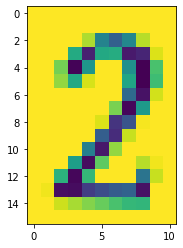

In [106]:
letter_image_file = 'extracted_letter_images/2/000001.png'

image = cv2.imread(letter_image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape) 
(h, w) = image.shape[:2] #cv.imread gets an array of h x w, h goes first
# add [:2] so that even if color image will work, not needed here though

plt.imshow(image)
plt.show()

Since `h > w`, we make sure `h` fits in our desired height value, e.g., 20:

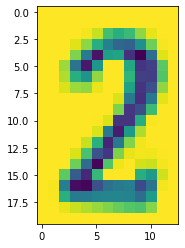

In [107]:
import imutils

image = imutils.resize(image, height=20)
# imutils.resize maintains the aspect ratio

plt.imshow(image)
plt.show()

Now we pad along width to make the image square, i.e., 20 x 20:

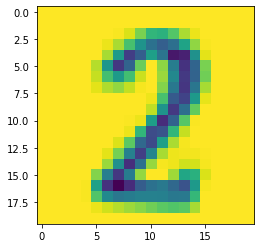

In [108]:
# determine the padding values for the width (= 20)
# to obtain the target dimensions
padW = int((20 - image.shape[1]) / 2.0) # may have rounding

# pad the image
image = cv2.copyMakeBorder(image, 0, 0, padW, padW,
        cv2.BORDER_REPLICATE)

# apply one more resizing to handle any rounding issues
image = cv2.resize(image, (20, 20))

plt.imshow(image)
plt.show()

Using what you learned, now write a function to resize images. Note that you also need to handle the possible case `h < w`:

In [109]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    - param image: image to resize
    - param width: desired width in pixels
    - param height: desired height in pixels
    - return: the resized image
    """

    (h, w) = image.shape[:2] 

    if w > h:
        image = imutils.resize(image, width=width)

    else:
        image = imutils.resize(image, height=width)

   
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((width - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (20,20))

    # return the pre-processed image
    return image

Prepare the training and validating datasets:

In [110]:
from imutils import paths

# initialize the data and labels
data_labels = []

progress_folder = ''

# loop over the input images
# imutils.paths.list_images will list all images in the 32 subfolders
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]
    # extracted_letter_images/2/000001.png, after split
    # extracted_letter_images, 2, 000001.png
    # so 2 is the 2nd last, accessed using index -2
    
    if label != progress_folder:
        print('Processing Folder', label)
        progress_folder = label
    
    # Add the letter image and it's label to our training data
    data_labels.append((image,label))

Processing Folder 2
Processing Folder 3
Processing Folder 4
Processing Folder 5
Processing Folder 6
Processing Folder 7
Processing Folder 8
Processing Folder 9
Processing Folder A
Processing Folder B
Processing Folder C
Processing Folder D
Processing Folder E
Processing Folder F
Processing Folder G
Processing Folder H
Processing Folder J
Processing Folder K
Processing Folder L
Processing Folder M
Processing Folder N
Processing Folder P
Processing Folder Q
Processing Folder R
Processing Folder S
Processing Folder T
Processing Folder U
Processing Folder V
Processing Folder W
Processing Folder X
Processing Folder Y
Processing Folder Z


In [111]:
# shuffling training data, as we will use part of it for validation and we need labels to be balanced

import random

random.shuffle(data_labels)
data = [x[0] for x in data_labels]
labels = [x[1] for x in data_labels]

Convert lists into NumPy arrays as required by Keras for input + data normalization:

In [112]:
# scale the raw pixel intensities to the range [0, 1] (this is important!!!)
data = np.array(data, dtype="float") / 255.0

# you may also use std rather than 255, and center the data by mean as follows:
#data = (np.array(data, dtype="float") - data.mean()) / data.std()
# in this case you need to remember the mean and std for use during testing later

# scaling is not needed if you use BatchNormalization after Conv2D and before Activation

labels = np.array(labels)

Split into training and validation datasets:

In [113]:
from sklearn.preprocessing import LabelBinarizer

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(labels)
print(lb.classes_)
labels = lb.transform(labels)
print()
print(labels)

['2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K'
 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [114]:
import pickle

MODEL_LABELS_FILENAME = "model_labels.dat"

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

In [ ]:
!pip install tensorflow

Now we are ready to train it using Keras. We’ll use a simple convolutional neural network architecture with two convolutional layers and two fully-connected layers:

In [ ]:
!pip install keras

In [115]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

clear_session() # free existing Keras models

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

In [116]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 50)        9050      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1250)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               625500    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1

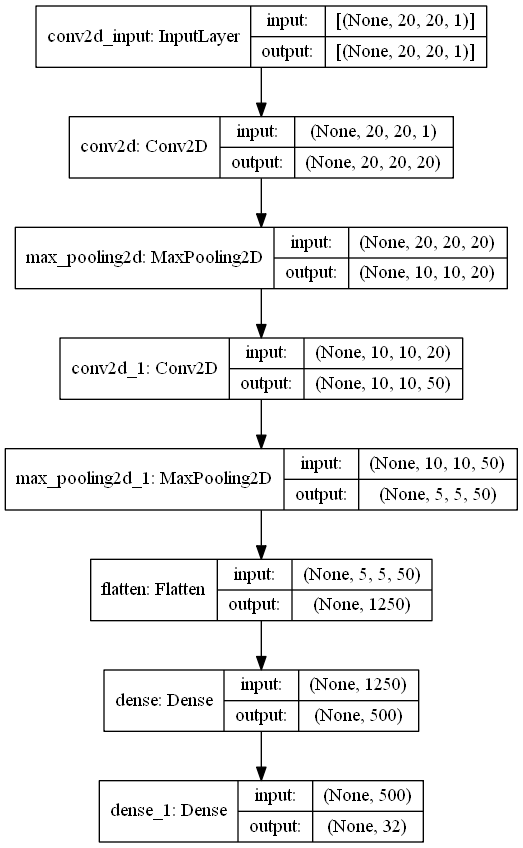

In [117]:
#from tensorflow.keras.utils import plot_model
from keras.utils import plot_model # if does not work properly, try the previous line instead

MODEL_PLOT_FILE = 'model_plot.png'
plot_model(model, to_file=MODEL_PLOT_FILE, show_shapes=True, show_layer_names=True)
display(Image(filename=MODEL_PLOT_FILE))

Questions: (1) Why `conv2d_1` has 9050 parameters? (2) Why `dense` has 625500 parameters?

Hint: self-study http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture5.pdf
    
**Type Your Answer Here:**


Now, let us do the actual training:

In [118]:
# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [119]:
# Train the neural network, 20% of the data is used for validation
model.fit(data, labels, validation_split=0.20, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
994/994 [==============================] - 23s 22ms/step - loss: 0.9059 - accuracy: 0.7840 - val_loss: 0.1038 - val_accuracy: 0.9864
Epoch 2/10
994/994 [==============================] - 22s 22ms/step - loss: 0.0803 - accuracy: 0.9881 - val_loss: 0.0858 - val_accuracy: 0.9887
Epoch 3/10
994/994 [==============================] - 22s 22ms/step - loss: 0.0710 - accuracy: 0.9897 - val_loss: 0.0844 - val_accuracy: 0.9884
Epoch 4/10
994/994 [==============================] - 22s 22ms/step - loss: 0.0583 - accuracy: 0.9906 - val_loss: 0.0874 - val_accuracy: 0.9887
Epoch 5/10
994/994 [==============================] - 22s 22ms/step - loss: 0.0504 - accuracy: 0.9912 - val_loss: 0.0830 - val_accuracy: 0.9897
Epoch 6/10
994/994 [==============================] - 22s 22ms/step - loss: 0.0520 - accuracy: 0.9904 - val_loss: 0.0834 - val_accuracy: 0.9893
Epoch 7/10
994/994 [==============================] - 23s 23ms/step - loss: 0.0433 - accuracy: 0.9916 - val_loss: 0.0832 - val_accuracy:

Save the model for later use:

In [120]:
MODEL_FILENAME = "captcha_model.hdf5"

# Save the trained model to disk
model.save(MODEL_FILENAME)

In [121]:
#See what will happen if you do not scale your data by 255.0?
#HINT: simply train again with data/255.0 instead of 255, and see how the loss and acc look like;
#      you need to recreate your model by running the cell containing clear_session() before

#[YOUR CODE HERE]

data = np.array(data, dtype="float") / 255
labels = np.array(labels)

lb = LabelBinarizer().fit(labels)
labels = lb.transform(labels)


from tensorflow.python.keras.backend import clear_session
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

clear_session() # clear the existing keras models

# It the builds the neural network!
model = Sequential()

# max pooling of intial convo. layer
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# max pooling of second convo. layer
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 500 nodes hidden layer
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# 32 nodes output layer
model.add(Dense(32, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network, 20% of the data is used for validation
model.fit(data, labels, validation_split=0.20, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
994/994 [==============================] - 22s 22ms/step - loss: 2.9765 - accuracy: 0.1825 - val_loss: 0.4290 - val_accuracy: 0.9343
Epoch 2/10
994/994 [==============================] - 21s 22ms/step - loss: 0.3266 - accuracy: 0.9563 - val_loss: 0.2427 - val_accuracy: 0.9759
Epoch 3/10
994/994 [==============================] - 22s 22ms/step - loss: 0.1915 - accuracy: 0.9769 - val_loss: 0.2135 - val_accuracy: 0.9786
Epoch 4/10
994/994 [==============================] - 21s 22ms/step - loss: 0.1575 - accuracy: 0.9811 - val_loss: 0.1661 - val_accuracy: 0.9818
Epoch 5/10
994/994 [==============================] - 22s 22ms/step - loss: 0.1298 - accuracy: 0.9814 - val_loss: 0.1525 - val_accuracy: 0.9821
Epoch 6/10
994/994 [==============================] - 22s 22ms/step - loss: 0.1317 - accuracy: 0.9835 - val_loss: 0.1415 - val_accuracy: 0.9839
Epoch 7/10
994/994 [==============================] - 23s 23ms/step - loss: 0.1166 - accuracy: 0.9834 - val_loss: 0.1357 - val_accuracy:

## Step 3: Use the model to solve CAPTCHAs!

The rest part can be run independently once models are saved.

Get an image from the online demo: https://contactform7.com/captcha/ and try our model on it:

In [122]:
# replace the url with the link of the image you see
# [Using the same image will cause points deducted !!!]
# !wget https://contactform7.com/captcha/
# use the name of the file you downloaded
TEST_FILE_NAME = '415684452.png'

# show the image
from IPython.display import Image

display(Image(filename=TEST_FILE_NAME))

Load saved model data:

In [123]:
from tensorflow.keras.models import load_model
import pickle

MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"

# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

Load packages and define functions for independent running of Part 3:

In [124]:
import numpy as np
import imutils
import cv2

# [!!! please also run the cell defining function "resize_to_fit" again, if you run Part 3 alone]

def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    - param image: image to resize
    - param width: desired width in pixels
    - param height: desired height in pixels
    - return: the resized image
    """

    (h, w) = image.shape[:2] 

    if w > h:
        image = imutils.resize(image, width=width)

    else:
        image = imutils.resize(image, height=width)

   
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((width - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (20,20))

    # return the pre-processed image
    return image

Get the letters from the downloaded images:

In [125]:
# Load the image and convert it to grayscale
image = cv2.imread(TEST_FILE_NAME)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

# threshold the image (convert it to pure black and white)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find the contours (continuous blobs of pixels) the image
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# !!! if the cell reports error, replace [0] above with [1]

letter_image_regions = []

# Now we can loop through each of the four contours and extract the letter
# inside of each one
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    letter_image_regions.append((x, y, w, h))

# If we found more or less than 4 letters in the captcha, our letter extraction
# didn't work correcly. Skip the image instead of saving bad training data!
if len(letter_image_regions) != 4:
    print('[WARNING]', TEST_FILE_NAME, 'has', len(letter_image_regions), 'contours, unable to process')
else:
    print('[SUCCESS]')

[SUCCESS]


If you see a warning, use another image instead and repeat the previous steps.

Otherwise, continue to create an output image:

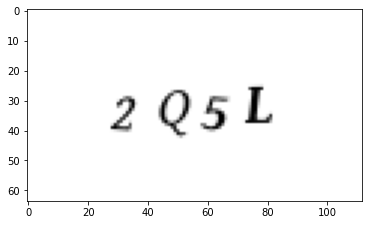

In [126]:
# Sort the detected letter images based on the x coordinate to make sure
# we are processing them from left-to-right so we match the right image
# with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

# Create an output image and a list to hold our predicted letters
output = cv2.merge([gray] * 3) # 2D gray image -> 3D color image

# show the 3D image
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(output)
plt.show()

CAPTCHA text is: 2Q5L


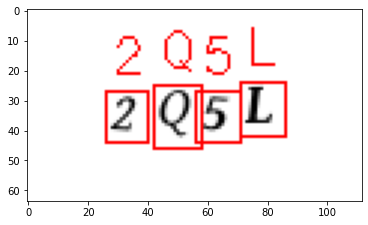

In [127]:
predictions = []

# Save out each letter as a single image
for letter_bounding_box in letter_image_regions:
    # Grab the coordinates of the letter in the image
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2-pixel margin around the edge
    letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

    # Re-size the letter image to 20x20 pixels to match training data
    letter_image = resize_to_fit(letter_image, 20, 20)
    
    # Turn the single image into a 4D list of images to make Keras happy
    # 4D: image_number (=1) x height x width x channel (=1)
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)
    
    # Ask the neural network to make a prediction
    prediction = model.predict(letter_image) # output is one-hot encoded
        
    letter = lb.inverse_transform(prediction)[0]
    # use [0] since there is only one test data's label item in the list
    predictions.append(letter)
    
    # draw the prediction on the output image
    # (255, 0, 0) = red
    cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (255, 0, 0), 1)
    cv2.putText(output, letter, (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 0, 0), 1)

# see prediction result:

# Print the captcha's text
captcha_text = "".join(predictions)
print("CAPTCHA text is: {}".format(captcha_text))

# Show the annotated image
plt.imshow(output)
plt.show()

Questions: Is the prediction correct? How many letters are correctly predicted?
    
**Type Your Answer Here:**
The prediction is correct. All four letters are correctly predicted as 2Q5L.